<a href="https://colab.research.google.com/github/anil2k/yolov8-sam/blob/main/yolov8_sam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.2/614.2 kB 8.5 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO

In [3]:
import cv2
from matplotlib import pyplot as plt
import copy


100%|██████████| 6.23M/6.23M [00:00<00:00, 188MB/s]

100%|██████████| 72.8k/72.8k [00:00<00:00, 104kB/s] 
image 1/1 /content/48197202308221443103127.jpg: 640x480 1 dog, 1 tie, 410.5ms
Speed: 17.3ms preprocess, 410.5ms inference, 22.6ms postprocess per image at shape (1, 3, 640, 480)


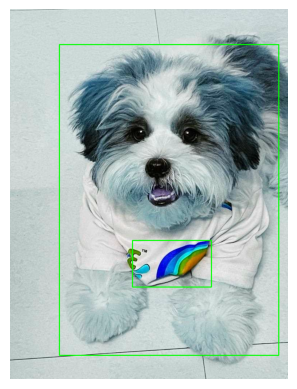

In [4]:
# load the YOLOv8 model
model = YOLO('yolov8n.pt')

# run the model on the image
results = model.predict(source='https://www.mrnmrspet.com/Files/82023/48197202308221443103127.jpg', conf=0.25)
predicted_boxes = results[0].boxes.xyxy


# read in the image for visualization
image_bgr = cv2.imread('/content/48197202308221443103127.jpg', cv2.IMREAD_COLOR)
image=image_bgr.copy()

# use cv2 to visualize the bounding boxes on the image
for box in predicted_boxes:
 cv2.rectangle(image_bgr, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
#cv2.imshow("YOLOv8 predictions", image_bgr)
# Display the image using matplotlib
plt.imshow(image_bgr)
plt.axis('off')  # Hide the axis
plt.show()

In [5]:
first_run = True
if first_run:
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

/bin/bash: line 1: {sys.executable}: command not found
--2023-09-09 06:11:01--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 99.84.208.90, 99.84.208.60, 99.84.208.36, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|99.84.208.90|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   176MB/s    in 11s     

2023-09-09 06:11:12 (218 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [6]:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.0.1+cu118
Torchvision version: 0.15.2+cu118
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ieovnsi5
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ieovnsi5
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36586 sha256=c694dacb05d0ec7821585baedd72cb8a600fb4e5d39269ceb34a5d9ebcd1a78b
  Stored in directory: /tmp/pip-ephem-wheel-cache-rfbtgayo/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2023-09-09 06:11:33--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.

In [7]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# predictor = SamPredictor(sam)


In [8]:
# load the SAM model
# sam = sam_model_registry["vit_h"](checkpoint="/sam_vit_h_4b8939.pth").to(device=torch.device('cuda:0'))

mask_predictor = SamPredictor(sam)

# transform the YOLOv8 predicted boxes to match input format expected by SAM model
transformed_boxes = mask_predictor.transform.apply_boxes_torch(predicted_boxes, image.shape[:2])

# run SAM model on all the boxes
mask_predictor.set_image(image)
masks, scores, logits = mask_predictor.predict_torch(
   boxes = transformed_boxes,
   multimask_output=False,
   point_coords=None,
   point_labels=None
)

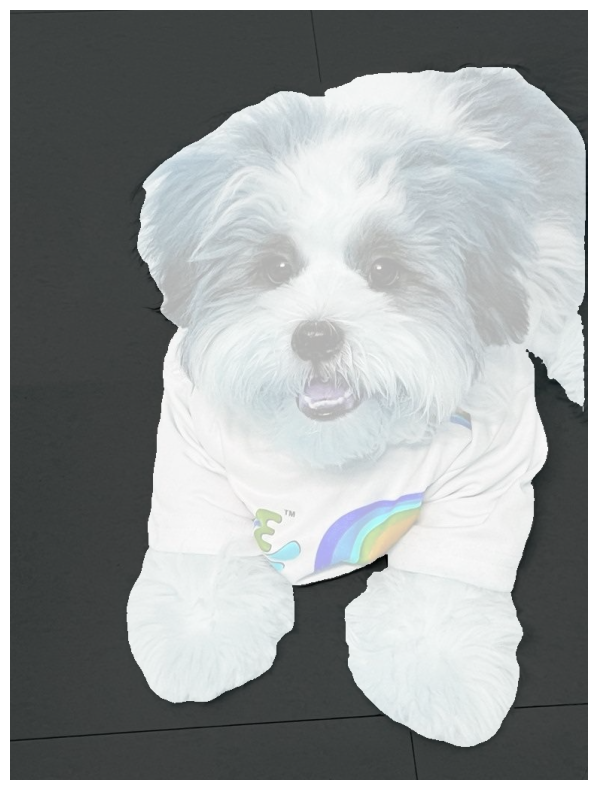

In [11]:
import numpy as np
# combine all masks into one for easy visualization
final_mask = None
for i in range(len(masks) - 1):
  if final_mask is None:
    final_mask = np.bitwise_or(masks[i][0], masks[i+1][0])
  else:
    final_mask = np.bitwise_or(image, masks[i+1][0])

# visualize the predicted masks
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.imshow(final_mask, cmap='gray', alpha=0.7)
plt.axis('off')  # Hide the axis
plt.show()

2


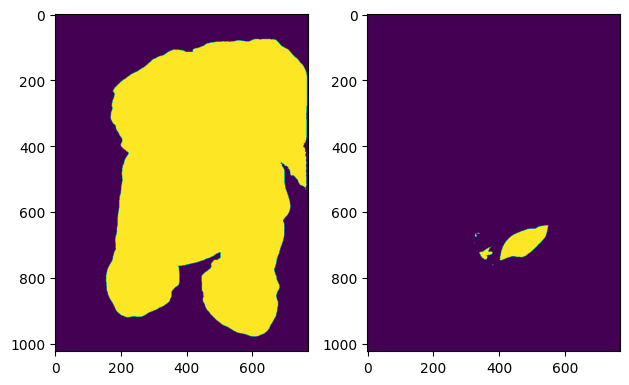

In [10]:
num_mask=len(masks)
print(num_mask)

num_cols = 2  # Number of columns (adjust as per your preference)
num_rows = (num_mask + num_cols - 1) // num_cols  # Calculate the number of rows needed

# Create a figure and specify the number and arrangement of subplots
fig, axs = plt.subplots(num_rows, num_cols)

# Flatten the axs array if only one row or column
if num_rows == 1:
    axs = [axs]

# Iterate over the image data and display each image in a subplot
for i in range(num_rows):
    for j in range(num_cols):
        index = i * num_cols + j
        if index <num_mask:
            axs[i][j].imshow(masks[index][0])
        else:
            axs[i][j].axis('off')  # Hide empty subplots

plt.tight_layout()  # Adjust spacing between subplots
plt.show()